# 02_NYC_data_generator

## NOTE: This notebook is currently incomplete. 

## An updated version will be pushed to the GitHub repo once it is complete

Member of the team:
- An Hoang
- Michael Sedelmeyer
- Mark McDonald


### Inputs:

**1. ../data/interim/Capital_Projects_clean.csv**

A cleansed version of the Capital_Projects.csv file, wherein each record represents one project change.

### Outputs:

**1. ../data/interim/.csv**

A version of the Capital_Projects.csv file, wherein each record represents one unique project with summary information regarding all associated project changes.

## Notebook Index

<a name='index'></a>

### 1) Notebook Setup 
&emsp; &emsp; <a href=#imports>Imports</a>  // <a href=#helpers>Helper Functions</a> // <a href=#read>Read Dataset</a>

### 2) Analysis

#### &emsp; &emsp; a) <a href=#cleanup>Data Cleanup</a>

#### &emsp; &emsp; b) <a href=#counts>Counts</a>

#### &emsp; &emsp; c) <a href=#trends>Trends</a>

#### &emsp; &emsp; d) <a href=#budget>Budget Values</a>

#### &emsp; &emsp; e) <a href=#missing>"Missing-ness"</a>

#### &emsp; &emsp; f) <a href=#summary>Summary & Findings</a>

#### &emsp; &emsp; g) <a href=#open>Open Items / Unanswered</a>

### 3) Save dataframes to .csv
&emsp; &emsp; <a href=#save>Save dataframes to CSV</a>

<a name='imports'></a>

## Imports
Imports for function used in this notebook.

<a href=#index>index</a>

In [39]:
import os
import math
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format
import logging

# Improve resolution of output graphcis
%config InlineBackend.figure_format ='retina'

<a name='helpers'></a>
## Helper Functions
Functions used to accomplish repeated tasks in this notebook.

<a href=#index>index</a>

<a name='read'></a>
## Read Dataset
Read the dataset and perform basic manipulation of headers and some fields including formatting.

<a href=#index>index</a>

In [42]:
predict_interval = 3 # number of years, None if all changes

file_path = '../data/interim/Capital_Projects_clean.csv'
save_path = '../data/interim/NYC_capital_projects_{}yr.csv'.format(predict_interval)

if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [43]:
data = pd.read_csv(file_path)

In [44]:
# entries
print(f"Number of dataset records: {len(data)}")

# num projects
print(f"Number of unique projects in dataset: {len(data['PID'].unique())}")

Number of dataset records: 2095
Number of unique projects in dataset: 355


In [45]:
datetime_cols = [
    'Date_Reported_As_Of',
    'Design_Start',
    'Original_Schedule',
    'Forecast_Completion'
]

for col in datetime_cols:
    data[col] = pd.to_datetime(data[col])
    
# make sure data is sorted properly
data = data.sort_values(by=['PID', 'PID_Index'])

In [46]:
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2095 entries, 0 to 2094
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Record_ID                2095 non-null   object        
 1   Date_Reported_As_Of      2095 non-null   datetime64[ns]
 2   PID                      2095 non-null   int64         
 3   Project_Name             2095 non-null   object        
 4   Description              2095 non-null   object        
 5   Category                 2095 non-null   object        
 6   Borough                  2095 non-null   object        
 7   Managing_Agency          2095 non-null   object        
 8   Client_Agency            2095 non-null   object        
 9   Current_Phase            2095 non-null   object        
 10  Design_Start             2095 non-null   datetime64[ns]
 11  Original_Budget          2095 non-null   float64       
 12  Budget_Forecast          2095 non-

,Record_ID,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,...,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,PID_Index,Change_Years,Change_Year,Current_Project_Years,Current_Project_Year
0,3-0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,...,"-4,318,643.37",2020-01-13,2020-01-14,1.00,270.00,0,0.60,1,5.94,6
1,3-1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,...,"-4,318,643.37",2020-01-13,2020-07-19,187.00,270.00,1,1.36,2,5.94,6
2,3-2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,...,"-4,318,643.37",2020-01-13,2020-08-08,20.00,270.00,2,1.85,2,5.94,6


# Define data generator functions and default parameters

In [138]:
def extract_project_details(df, copy_columns, column_rename_dict=None,
                            use_record=0, record_index='PID_Index'):
    """
    """
    df_details = df.copy().loc[df[record_index]==use_record][copy_columns]
    
    if column_rename_dict:
        df_details = df_details.copy().rename(columns=column_rename_dict) 
    
    return df_details.set_index('PID')


def subset_project_changes(df, change_year_interval=3, change_col='Change_Year',
                           project_age_col='Current_Project_Year', inclusive_stop=True):
    """
    """
    df_subset = df.copy().loc[
        (df[change_col]<=change_year_interval) & (
            df[project_age_col]>=change_year_interval if inclusive_stop
            else df[project_age_col]>change_year_interval
        )
    ]
    
    return df_subset.set_index('Record_ID')


def find_max_record_indices(df, record_index='PID_Index'):
    """
    """
    df_group = df.groupby('PID').agg({record_index: max})
    pid_dict = dict(zip(df_group.index, df_group.values.ravel()))
    record_id_indices = [
        str(pid) + '-' + str(pid_index)
        for pid, pid_index in pid_dict.items()
    ]
    
    return record_id_indices


def project_interval_endstate(df, keep_columns, column_rename_dict=None,
                              change_year_interval=None, record_index='PID_Index',
                              change_col='Change_Year', project_age_col='Current_Project_Year',
                              inclusive_stop=True):
    """
    """
    if change_year_interval:
        df = subset_project_changes(
            df.copy(), change_year_interval, change_col, project_age_col, inclusive_stop)
    else:
        df = df.copy().set_index('Record_ID')
    
    max_record_list = find_max_record_indices(df, record_index)
    
    df_endstate = df.copy().loc[max_record_list][keep_columns]
    
    if column_rename_dict:
            df_endstate = df_endstate.copy().rename(columns=column_rename_dict)
    
    return df_endstate.set_index('PID')


def join_data_endstate(df_details, df_endstate, how='inner'):
    """
    """
    df_join = pd.merge(df_details, df_endstate, how=how, left_index=True, right_index=True)
    
    return df_join


def add_change_features(df):
    """
    """
    # copy input for comparison of outputs
    df_copy = df.copy()

    # calculate interval change features
    df_copy['Duration_Start'] = (df_copy['Schedule_Start'] - df_copy['Design_Start']).dt.days
    df_copy['Duration_End'] = (df_copy['Schedule_End'] - df_copy['Design_Start']).dt.days
    df_copy['Schedule_Change'] = df_copy['Duration_End'] - df_copy['Duration_Start']
    df_copy['Budget_Change'] = df_copy['Budget_End'] - df_copy['Budget_Start']

    # define schedule change ratio
    df_copy['Schedule_Change_Ratio'] = df_copy['Schedule_Change']/df_copy['Duration_Start']
    # define budget change ratio
    df_copy['Budget_Change_Ratio'] = df_copy['Budget_Change']/df_copy['Budget_Start']
    
    # define project metrics
    df_copy['Budget_Abs_Per_Error'] = (
        df_copy['Budget_Start'] - df_copy['Budget_End']
    ).abs() / df_copy['Budget_End']
    
    df_copy['Budget_Rel_Per_Error'] = (
        df_copy['Budget_Start'] - df_copy['Budget_End']
    ).abs() / df_copy['Budget_Start']
   
    df_copy['Duration_End_Ratio'] = df_copy['Duration_End']/df_copy['Duration_Start']
    df_copy['Budget_End_Ratio'] = df_copy['Budget_End']/df_copy['Budget_Start']

    # previously titled 'Mark Metric'
    df_copy['Duration_Ratio_Inv'] = (df_copy['Duration_Start']/df_copy['Duration_End']) - 1
    df_copy['Budget_Ratio_Inv'] = (df_copy['Budget_Start']/df_copy['Budget_End']) - 1
    
    return df_copy


In [141]:
predict_interval = 3

keep_columns = [
    'Date_Reported_As_Of',
    'Change_Years',
    'PID',
    'Current_Phase',
    'Budget_Forecast',
    'Forecast_Completion',
    'PID_Index',
]

column_rename_dict = {
    'Date_Reported_As_Of': 'Final_Change_Date',
    'Current_Phase': 'Phase_End',
    'Budget_Forecast': 'Budget_End',
    'Forecast_Completion': 'Schedule_End',
    'PID_Index': 'Number_Changes',
    'Change_Years': 'Final_Change_Years'
}

df_endstate = project_interval_endstate(
    data, keep_columns, column_rename_dict, change_year_interval=predict_interval
)

df_endstate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 3 to 1004
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Final_Change_Date   149 non-null    datetime64[ns]
 1   Final_Change_Years  149 non-null    float64       
 2   Phase_End           149 non-null    object        
 3   Budget_End          149 non-null    float64       
 4   Schedule_End        149 non-null    datetime64[ns]
 5   Number_Changes      149 non-null    int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(1)
memory usage: 8.1+ KB


In [142]:
copy_columns = [
    'PID',
    'Project_Name',
    'Description',
    'Category',
    'Borough',
    'Managing_Agency',
    'Client_Agency',
    'Current_Phase',
    'Current_Project_Years',
    'Current_Project_Year',
    'Design_Start',
    'Original_Budget',
    'Original_Schedule',
]

column_rename_dict = {
    'Current_Phase': 'Phase_Start',
    'Original_Budget': 'Budget_Start',
    'Original_Schedule': 'Schedule_Start',
}

df_details = extract_project_details(data, copy_columns, column_rename_dict)

df_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 355 entries, 3 to 1014
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project_Name           355 non-null    object        
 1   Description            355 non-null    object        
 2   Category               355 non-null    object        
 3   Borough                355 non-null    object        
 4   Managing_Agency        355 non-null    object        
 5   Client_Agency          355 non-null    object        
 6   Phase_Start            355 non-null    object        
 7   Current_Project_Years  355 non-null    float64       
 8   Current_Project_Year   355 non-null    int64         
 9   Design_Start           355 non-null    datetime64[ns]
 10  Budget_Start           355 non-null    float64       
 11  Schedule_Start         355 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(7)
memory us

In [143]:
df_merged = join_data_endstate(df_details, df_endstate)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 3 to 1004
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project_Name           149 non-null    object        
 1   Description            149 non-null    object        
 2   Category               149 non-null    object        
 3   Borough                149 non-null    object        
 4   Managing_Agency        149 non-null    object        
 5   Client_Agency          149 non-null    object        
 6   Phase_Start            149 non-null    object        
 7   Current_Project_Years  149 non-null    float64       
 8   Current_Project_Year   149 non-null    int64         
 9   Design_Start           149 non-null    datetime64[ns]
 10  Budget_Start           149 non-null    float64       
 11  Schedule_Start         149 non-null    datetime64[ns]
 12  Final_Change_Date      149 non-null    datetime64[ns]
 13  Fina

In [153]:
df_features = add_change_features(df_merged)
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 3 to 1004
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project_Name           149 non-null    object        
 1   Description            149 non-null    object        
 2   Category               149 non-null    object        
 3   Borough                149 non-null    object        
 4   Managing_Agency        149 non-null    object        
 5   Client_Agency          149 non-null    object        
 6   Phase_Start            149 non-null    object        
 7   Current_Project_Years  149 non-null    float64       
 8   Current_Project_Year   149 non-null    int64         
 9   Design_Start           149 non-null    datetime64[ns]
 10  Budget_Start           149 non-null    float64       
 11  Schedule_Start         149 non-null    datetime64[ns]
 12  Final_Change_Date      149 non-null    datetime64[ns]
 13  Fina

### Drop projects that are missing critical date and budget metrics

**OBSERVATION:**

IT projects don't seem to follow the patterns/rules of other projects

### Examine relationships between metrics by project

In [61]:
print(
    'The resulting dataframes will be saved to .csv at the following path locations:\n'
)
for save_path in [save_path_cleansed, save_path_pid, save_path_melted]:
    print(save_path)

The resulting dataframes will be saved to .csv at the following path locations:

../data/interim/Capital_Projects_clean.csv
../data/interim/Capital_Projects_pid.csv
../data/interim/Capital_Projects_melted.csv


In [62]:
data.to_csv(save_path_cleansed, index=False)
df_pid.to_csv(save_path_pid, index=False)
df_pid_melted.to_csv(save_path_melted, index=False)

In [65]:
data.head(3)

,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes
0,2014-05-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,2-Design,2013-09-23,"184,896,360.00","182,980,960.00","-1,915,400.00","-4,318,643.37",2020-01-13,2020-01-14,1.00,270.00
1,2015-02-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,2013-09-23,"184,896,360.00","168,751,769.00","-14,229,191.00","-4,318,643.37",2020-01-13,2020-07-19,187.00,270.00
2,2015-08-01,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,3-Construction Procurement,2013-09-23,"184,896,360.00","165,532,447.00","-3,219,322.00","-4,318,643.37",2020-01-13,2020-08-08,20.00,270.00


In [66]:
data['Date_Reported_As_Of'].describe()

count                    2150
unique                     15
top       2019-05-01 00:00:00
freq                      296
first     2013-09-01 00:00:00
last      2019-09-01 00:00:00
Name: Date_Reported_As_Of, dtype: object

In [68]:
df_pid.head(3)

,PID,Project_Name,Category,Borough,Managing_Agency,Client_Agency,Number_Changes,Original_Budget,Design_Start,Original_Schedule,...,Total_Schedule_Changes,Total_Budget_Changes,Original_Duration,Budget_Change_Ratio,Schedule_Change_Ratio,Budget_To_Date,Budget_Abs_Per_Error,Budget_Rel_Per_Error,Mark_Metric,Budget_Ratios
0,3,26th Ward Waste Water Treatment Plant Prelimin...,Wastewater Treatment,Brooklyn,DEP,DEP,13,"184,896,360.00",2013-09-23,2020-01-13,...,270.00,"-4,318,643.37","2,303.00",-0.02,0.12,"180,577,716.63",0.02,0.02,0.02,0.98
1,7,Bowery Bay Waste Water Treatment Plant Main Se...,Wastewater Treatment,Queens,DEP,DEP,15,"53,493,000.00",2013-05-01,2018-03-31,...,685.00,"15,305,457.00","1,795.00",0.29,0.38,"68,798,457.00",0.22,0.29,-0.22,1.29
2,18,Croton Falls Pumping Station Construction,Water Supply,Carmel,DEP,DEP,15,"66,616,435.00",2003-08-22,2017-05-31,...,"1,014.00","1,255,175.02","5,031.00",0.02,0.20,"67,871,610.02",0.02,0.02,-0.02,1.02


In [96]:
(data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425

0       0.60
1       1.36
2       1.85
3       2.27
4       2.69
        ... 
2254    4.07
2255    1.23
2256    4.09
2257   -0.04
2258    0.03
Length: 2150, dtype: float64

In [112]:
drop_pid_list = [pid[0] for pid in drop_pids]

In [113]:
drop_pid_list

[863, 910, 267, 403, 553, 723, 863, 910, 911, 1006]

In [101]:
data.copy().loc[data['Date_Reported_As_Of'].isnull()]

,Date_Reported_As_Of,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Current_Phase,Design_Start,Original_Budget,Budget_Forecast,Latest_Budget_Changes,Total_Budget_Changes,Original_Schedule,Forecast_Completion,Latest_Schedule_Changes,Total_Schedule_Changes,Current_Project_Year


In [103]:
df_pid['PID']==911

0      False
1      False
2      False
3      False
4      False
       ...  
358    False
359    False
360    False
361    False
362    False
Name: PID, Length: 355, dtype: bool

In [104]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

403    15
267    15
553     9
723     5
863     4
911     3
910     3
569     1
Name: PID, dtype: int64

In [115]:
data = data.copy().loc[~data['PID'].isin(drop_pid_list)]

In [116]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

569    1
Name: PID, dtype: int64

,PID,Design_Start
0,3,2013-09-23
1,7,2013-05-01
2,18,2003-08-22
3,25,2001-11-01
4,34,1996-05-01
...,...,...
358,1010,2015-08-06
359,1011,2018-06-07
360,1012,2015-07-31
361,1013,2019-09-16


In [121]:
design_start_dict = {
    key: value for key, value in zip(df_pid['PID'], df_pid['Design_Start'].values)
}

In [123]:
data['Design_Start'] = data['PID'].copy().map(design_start_dict)

In [124]:
data.copy().loc[data['Design_Start'].isnull()]['PID'].value_counts()

Series([], Name: PID, dtype: int64)

In [125]:
data['Current_Project_Year'] = (data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425
data['Current_Project_Year_Rd'] = (
    (data['Date_Reported_As_Of'] - data['Design_Start']).dt.days / 365.2425
).astype(int)

In [85]:
df_pid['Project_Years'] = (data['Date_Reported_As_Of'].max() - df_pid['Design_Start']).dt.days / 365.2425

In [86]:
df_pid['Project_Years_Rd'] = ((data['Date_Reported_As_Of'].max() - df_pid['Design_Start']).dt.days / 365.2425).astype(int)

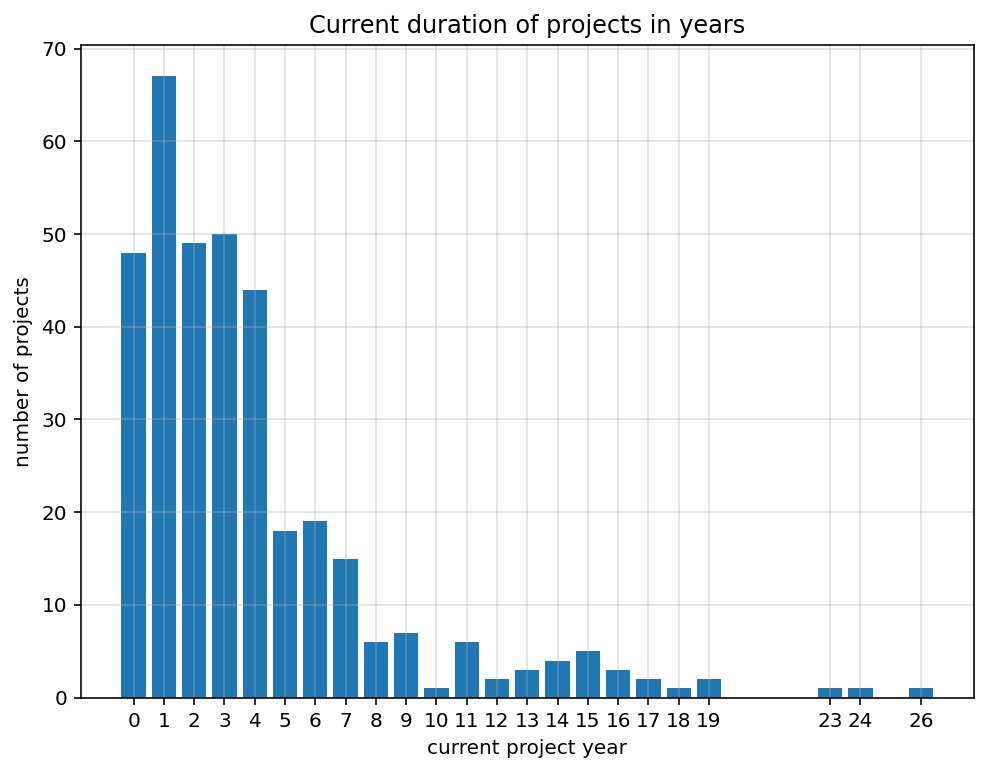

0     48
1     67
2     49
3     50
4     44
5     18
6     19
7     15
8      6
9      7
10     1
11     6
12     2
13     3
14     4
15     5
16     3
17     2
18     1
19     2
23     1
24     1
26     1
Name: Project_Years_Rd, dtype: int64


In [95]:
project_yrs = df_pid['Project_Years_Rd'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(project_yrs.index, project_yrs.values)
plt.title('Current duration of projects in years')
plt.grid(':', alpha=0.4)
plt.xticks(project_yrs.index)
plt.xlabel('current project year')
plt.ylabel('number of projects')
plt.show()

print(project_yrs)

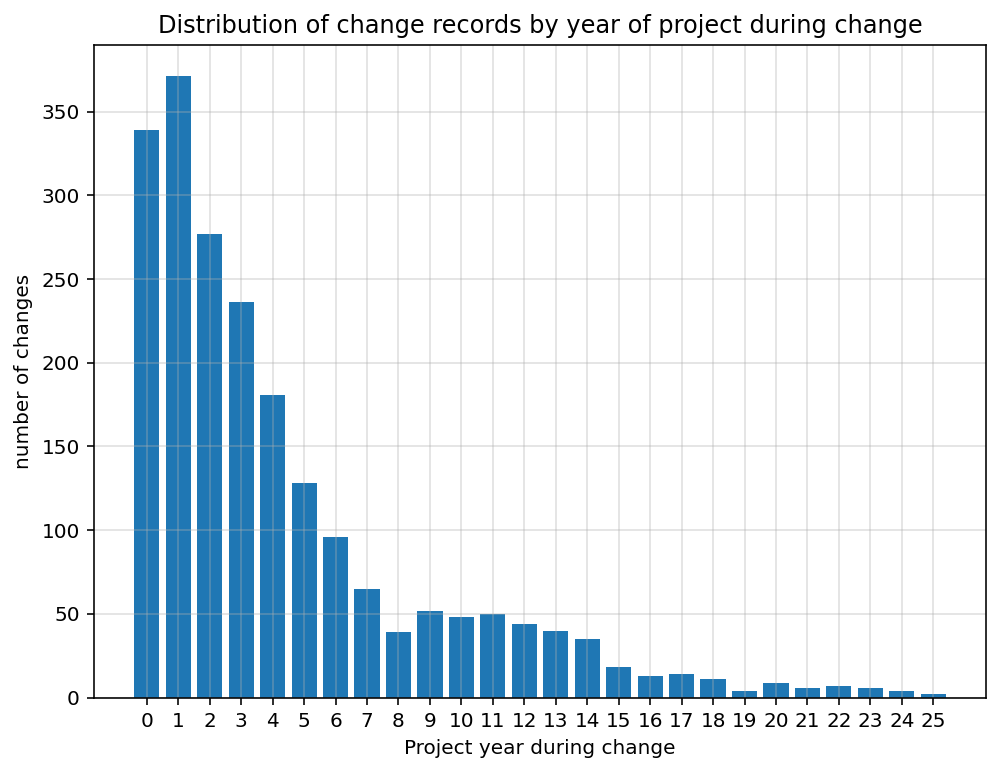

0     339
1     371
2     277
3     236
4     181
5     128
6      96
7      65
8      39
9      52
10     48
11     50
12     44
13     40
14     35
15     18
16     13
17     14
18     11
19      4
20      9
21      6
22      7
23      6
24      4
25      2
Name: Current_Project_Year_Rd, dtype: int64


In [127]:
change_yr = data['Current_Project_Year_Rd'].value_counts().sort_index()

plt.figure(figsize=(8,6))
plt.bar(change_yr.index, change_yr.values)
plt.title('Distribution of change records by year of project during change')
plt.grid(':', alpha=0.4)
plt.xticks(change_yr.index)
plt.xlabel('Project year during change')
plt.ylabel('number of changes')
plt.show()

print(change_yr)